# Cycle-frequency analysis in real EEG 
---

###  Summary
 1. Import raw data and compute breaths duration using events
 2. Apply notch (50Hz + harmonics) and high-pass (0.2Hz) filters
 3. Segment clean data in event-locked, fixed lenght epochs  
 4. Segment clean data in event-locked epochs, adapted to respiratory length
 5. Apply conventional time-frequency transformation
 6. and CF transformation
 6. Plot maps
 
 ----------------

Copyright (C) 2024 Xavier Navarro-Suné - All Rights Reserved

You may use, distribute and modify this code under the terms of the GNU GPL license. 

This program is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details.

You should have received a copy of the GNU General Public License along with this program. If not, see <http://www.gnu.org/licenses/>



## 0. Load pacakges

In [1]:
import mne
mne.set_log_level('error')

import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage
import autoreject 
from mne.time_frequency import tfr_morlet
from mne.stats import permutation_cluster_1samp_test

## 1. Import raw data and channel type adjustments

In [2]:
# VS stands for spontaneous ventilation or unloaded breathing (UB)
# LD stands for loaded breathing

raw_VS = mne.io.read_raw_fif('sample_unloaded_breathing.fif', preload=True)
raw_LD = mne.io.read_raw_fif('sample_loaded_breathing.fif', preload=True)

ch_names = np.load('ch_names.npy')

events_VS, event_dict_VS = mne.events_from_annotations(raw_VS)
event_mapping_VS = {'Insp VS':1129}
resp_dur_VS = np.diff(events_VS[1:-1,0])/raw_VS.info['sfreq']

events_LD, event_dict_LD = mne.events_from_annotations(raw_LD)
event_mapping_LD = {'Insp LD':1129}
resp_dur_LD = np.diff(events_LD[1:-1,0])/raw_LD.info['sfreq']


## 2. Apply notch and high-pass filters

In [3]:
# --------------------------- VS ------------------------------------------------
filt_VS = raw_VS
# Notch Filter 
filt_VS.notch_filter(np.arange(50, 201, 50), filter_length='auto' , phase='zero')

# High-pass
filt_VS.filter(0.2, 249., fir_design='firwin')


<Raw | sample_unloaded_breathing.fif, 36 x 301490 (603.0 s), ~82.9 MB, data loaded>

In [4]:
# --------------------------- LD ------------------------------------------------
filt_LD = raw_LD
# Notch Filter 
filt_LD.notch_filter(np.arange(50, 201, 50), filter_length='auto' , phase='zero')

# High-pass
filt_LD.filter(0.2, 249., fir_design='firwin')


<Raw | sample_loaded_breathing.fif, 36 x 301750 (603.5 s), ~82.9 MB, data loaded>

### Definition of generic parameters for cycle-frequency transformation

In [5]:
from CFA_functions import time_to_phase_average, time_to_phase_by_cycle

sfreq = raw_VS.info['sfreq']

# Time-phase parameters
ph_step = 1      # phase resolution ; Minimal value = 1 (recommended)
verbose = False  # show progress bar and other informations during transformation
ini_phase = -1/2
end_phase = 1/4

# TFR parameters
decim = 1
freqs = np.arange(6, 30, 0.5)  # define frequencies of interest
n_cycles = freqs/2


## 3. Segment filtered data in event-locked, fixed lenght epochs 

In [7]:
# Conventional EEG segmentation settings
tmin = -1.5
tmax = 0.5

times = 1e3 * np.arange(tmin,tmax,1/sfreq)

# Definition of maximal threshold to include short breaths
resp_th_VS = 25 # all trials
resp_th_LD = 25
keep_trial_VS = resp_dur_VS < resp_th_VS
keep_trial_LD = resp_dur_LD < resp_th_LD

In [8]:
# Take continous data, VS 
data_VS = filt_VS.get_data(picks='eeg')
triggers_VS = events_VS[1:-1,0]

max_ttot_VS = 6
min_ttot_VS = 1.25

In [9]:
# Take continous data, LD 
data_LD = filt_LD.get_data(picks='eeg')
triggers_LD = events_LD[1:-1,0]

max_ttot_LD = 6
min_ttot_LD = 1.25

In [10]:
# --------------------------- VS ------------------------------------------------

cfr_VS_, phases = time_to_phase_by_cycle(data_VS, sfreq, triggers_VS, ph_step, ini_phase, 
                                        end_phase, freqs, n_cycles, min_ttot_VS, max_ttot_VS, [tmin, tmax] ,verbose)

cfr_VS = cfr_VS_[keep_trial_VS,:,:,:]

In [11]:
# --------------------------- LD ------------------------------------------------

cfr_LD_, phases = time_to_phase_by_cycle(data_LD, sfreq, triggers_LD, ph_step, ini_phase, 
                                        end_phase, freqs, n_cycles, min_ttot_LD, max_ttot_LD, [tmin, tmax] ,verbose)

cfr_LD = cfr_LD_[keep_trial_LD,:,:,:]

## 4. Segment filtered data in epochs adapted to the average duration of breaths

In [12]:
# Conversion to phase
# Since Tinsp=Texp, each period correspond to half cycle (180 or pi rad)
nb_pi_partitions = 15 # nb of partitions of previous expiratory phase, i.e. nb of divisions of pi
nb_bl_partitions = 4 # nb of partitions to compute baseline

In [13]:
# --------------------------- VS ------------------------------------------------
med_resp_dur_VS = np.median(resp_dur_VS)

print("Mean duration of breaths VS: " + str(np.mean(resp_dur_VS)) + " ; Median: " + str(np.median(resp_dur_VS)) + " Std: " +str(np.std(resp_dur_VS)))

# Use adaptive BL settings 
# Define epochs based on mean duration of breathing (seconds)
tmin_VS_a = -med_resp_dur_VS/2  # consideration: Tinsp=Texp 
tmax_VS_a = med_resp_dur_VS/4 


Mean duration of breaths VS: 2.721707762557078 ; Median: 2.596 Std: 0.47070407429316036


In [14]:
cfr_VS_a_, _ = time_to_phase_by_cycle(data_VS, sfreq, triggers_VS, ph_step, ini_phase, 
                                end_phase, freqs, n_cycles, min_ttot_VS, max_ttot_VS, [tmin_VS_a, tmax_VS_a] ,verbose)

cfr_VS_a = cfr_VS_a_[keep_trial_VS,:,:,:]

In [15]:
# --------------------------- LD ------------------------------------------------
med_resp_dur_LD = np.median(resp_dur_LD)

print("Mean duration of breaths in LD: " + str(np.mean(resp_dur_LD)) + " ; Median: " + str(np.median(resp_dur_LD)) + " Std: " +str(np.std(resp_dur_LD)))

# Use adaptive BL settings 
# Define epochs based on mean duration of breathing (seconds)

tmin_LD_a = -med_resp_dur_LD/2  # consideration: Tinsp=Texp 
tmax_LD_a = med_resp_dur_LD/4 


Mean duration of breaths in LD: 8.984492307692308 ; Median: 8.7 Std: 2.01682821909191


In [16]:
cfr_LD_a_, _ = time_to_phase_by_cycle(data_LD, sfreq, triggers_LD, ph_step, ini_phase, 
                                end_phase, freqs, n_cycles, min_ttot_LD, max_ttot_LD, [tmin_LD_a, tmax_LD_a] ,verbose)

cfr_LD_a = cfr_LD_a_[keep_trial_LD,:,:,:]

## 5. Cycle-by-cycle data segmentation

In [17]:
# ------------------------------------------   VS    ------------------------------------------
cfr_by_cycle_VS_, ph_VS = time_to_phase_by_cycle(data_VS, sfreq, triggers_VS, ph_step, ini_phase, 
                                                 end_phase, freqs, n_cycles, min_ttot_VS, max_ttot_VS,0,verbose)

cfr_by_cycle_VS = cfr_by_cycle_VS_[keep_trial_VS,:,:,:]

In [18]:
# ------------------------------------------   LD    ------------------------------------------
cfr_by_cycle_LD_, ph_LD = time_to_phase_by_cycle(data_LD, sfreq, triggers_LD, ph_step, ini_phase, 
                                                 end_phase, freqs, n_cycles, min_ttot_LD, max_ttot_LD,0,verbose)

cfr_by_cycle_LD = cfr_by_cycle_LD_[keep_trial_LD,:,:,:]

/Users/xavier/work/notebooks/CF_analysis_functions.py:150: UserWarning: The duration of the cycle is longer than the maximal duration max_ttot
  warnings.warn(message = "The duration of the cycle is longer than the maximal duration max_ttot")


Cycle number: 1  triggers[i]= 7105 triggers[i-1]= 2755
ini= 4930 end 7930  final duration= 6.0
Cycle number: 2  triggers[i]= 11121 triggers[i-1]= 7105
ini= 9113 end 12113  final duration= 6.0
Cycle number: 3  triggers[i]= 16134 triggers[i-1]= 11121
ini= 13627 end 16627  final duration= 6.0
Cycle number: 4  triggers[i]= 20750 triggers[i-1]= 16134
ini= 18442 end 21442  final duration= 6.0
Cycle number: 5  triggers[i]= 27508 triggers[i-1]= 20750
ini= 24129 end 27129  final duration= 6.0
Cycle number: 6  triggers[i]= 32604 triggers[i-1]= 27508
ini= 30056 end 33056  final duration= 6.0
Cycle number: 7  triggers[i]= 37168 triggers[i-1]= 32604
ini= 34886 end 37886  final duration= 6.0
Cycle number: 8  triggers[i]= 41276 triggers[i-1]= 37168
ini= 39222 end 42222  final duration= 6.0
Cycle number: 9  triggers[i]= 45641 triggers[i-1]= 41276
ini= 43458 end 46458  final duration= 6.0
Cycle number: 10  triggers[i]= 49929 triggers[i-1]= 45641
ini= 47785 end 50785  final duration= 6.0
Cycle number: 1

In [23]:
# Baseline settings
apply_baseline = True
baseline_portion = 0.2 

ind1 = 15
ind2 = round(phases.size*baseline_portion+ind1)

# resampled time to have same x-resolution than phases
times_res = np.arange(-1.5,0.5,2/270) # Values adapted to parameters set in preprocessing pipeline 

x_vals   = np.array([[times_res[0], times_res[-1]],[phases[0], phases[-1]], [phases[0], phases[-1]]])

In [24]:
from CFA_functions import apply_baseline_CF_map, compute_itc_pfr

# --------------------------- VS ------------------------------------------------
# Apply baseline
relative_bl = 1 # 0: baseline subtraction ; 1: relative changes with respect BL

if apply_baseline:
    pow_cfr_VS = apply_baseline_CF_map(np.abs(cfr_VS),ind1,ind2,relative_bl)
    pow_cfr_VS_a  = apply_baseline_CF_map(np.abs(cfr_VS_a),ind1,ind2,relative_bl)
    pow_cfr_by_cycle_VS  = apply_baseline_CF_map(np.abs(cfr_by_cycle_VS),ind1,ind2,relative_bl)
else:
    pow_cfr_VS =  np.abs(cfr_VS)
    pow_cfr_VS_a_ = np.abs(cfr_VS_a)
    pow_cfr_by_cycle_VS_ = np.abs(cfr_by_cycle_VS)


# Average maps to obtain power and ITC
avg_pow_cfr_VS = np.nanmean(pow_cfr_VS,axis=0) #  use median to avoid outliers
#avg_pow_cfr_VS = np.nanmedian(pow_cfr_VS,axis=0) #  
itc_cfr_VS =  compute_itc_pfr(cfr_VS)

avg_pow_cfr_VS_a = np.nanmean(pow_cfr_VS_a,axis=0)
#avg_pow_cfr_VS_a = np.nanmedian(pow_cfr_VS_a,axis=0)
itc_cfr_VS_a = compute_itc_pfr(cfr_VS_a)

avg_pow_cfr_by_cycle_VS = np.nanmean(pow_cfr_by_cycle_VS, axis=0)
#avg_pow_cfr_by_cycle_VS = np.nanmedian(pow_cfr_by_cycle_VS, axis=0)
itc_cfr_by_cycle_VS = compute_itc_pfr(cfr_by_cycle_VS)


# Create 4D matrix containing images for plotting 
img_VS = np.stack([avg_pow_cfr_VS, itc_cfr_VS,
               avg_pow_cfr_VS_a, itc_cfr_VS_a,
               avg_pow_cfr_by_cycle_VS,itc_cfr_by_cycle_VS
               ])

In [25]:
# --------------------------- LD ------------------------------------------------
# Apply baseline
relative_bl = 1 # 0: baseline subtraction ; 1: relative changes with respect BL

if apply_baseline:
    pow_cfr_LD = apply_baseline_CF_map(np.abs(cfr_LD),ind1,ind2,relative_bl)
    pow_cfr_LD_a  = apply_baseline_CF_map(np.abs(cfr_LD_a),ind1,ind2,relative_bl)
    pow_cfr_by_cycle_LD  = apply_baseline_CF_map(np.abs(cfr_by_cycle_LD),ind1,ind2,relative_bl)
else:
    pow_cfr_LD =  np.abs(cfr_LD)
    pow_cfr_LD_a_ = np.abs(cfr_LD_a)
    pow_cfr_by_cycle_LD_ = np.abs(cfr_by_cycle_LD)


# Average maps to obtain power and ITC
avg_pow_cfr_LD = np.nanmean(pow_cfr_LD,axis=0) #  use median to avoid outliers
#avg_pow_cfr_LD = np.nanmedian(pow_cfr_LD,axis=0) #  
itc_cfr_LD =  compute_itc_pfr(cfr_LD)

avg_pow_cfr_LD_a = np.nanmean(pow_cfr_LD_a,axis=0)
#avg_pow_cfr_LD_a = np.nanmedian(pow_cfr_LD_a,axis=0)
itc_cfr_LD_a = compute_itc_pfr(cfr_LD_a)

avg_pow_cfr_by_cycle_LD = np.nanmean(pow_cfr_by_cycle_LD, axis=0)
#avg_pow_cfr_by_cycle_LD = np.nanmedian(pow_cfr_by_cycle_LD, axis=0)
itc_cfr_by_cycle_LD = compute_itc_pfr(cfr_by_cycle_LD)


# Create 4D matrix containing images for plotting 
img_LD = np.stack([avg_pow_cfr_LD, itc_cfr_LD,
               avg_pow_cfr_LD_a, itc_cfr_LD_a,
               avg_pow_cfr_by_cycle_LD,itc_cfr_by_cycle_LD
               ])


In [26]:
# Set plotting parameters
max_P = np.array([np.nanmax(img_VS[[0,2,4],:,:])*0.9, 1])
min_P = np.array([np.nanmin(img_VS[[0,2,4],:,:]), 0])

max_P_LD = np.array([np.nanmax(img_LD[[0,2,4],:,:])*0.9, 1])
min_P_LD = np.array([np.nanmin(img_LD[[0,2,4],:,:]), 0])


In [27]:

cmap_P = 'jet'  

# Axis and ticks

xtick_vals  = np.array([
                       [-1.5, -1,  -0.5, -0.25, 0, 0.25, 0.5],
                       [-180, -135, -90, -45,   0, 45,   90],
                       [-180, -135, -90, -45,   0, 45,   90]
                       ])
                       

xtick_labels = np.array([
                        ['-1.5',  '-1', '-0.5',   ' ',  '0', ' ', '0.5'],
                        ['-π', '-3π/4', '-π/2', '-π/4', '0','π/4', 'π/2'],
                        ['-π', '-3π/4', '-π/2', '-π/4', '0','π/4', 'π/2']
                        ])

xlabels = np.array([ 
                    'Time (s)','Time (s)', 
                    'Phase (rad)', 'Phase (rad)', 
                    'Phase (rad)', 'Phase (rad)'
                   ])


clabels = np.array(['Power', 'ITC'])

# Text settings
text_kwargs = dict(ha='center', va='center', fontsize=18, color='k')
x_txt = [0.085, 0.535]
y_txt = [0.87, 0.59, 0.30]
txts  = ['A1','A2','B1','B2','C1','C2']

xy_TF = (-1.4, 25)
xy_PF = (-165, 25)
xres  = np.array([140, 1, 1]) 
ch = [2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14,17, 18, 19, 20, 22, 23, 24, 25, 26]

### Power plots of TF and CF maps

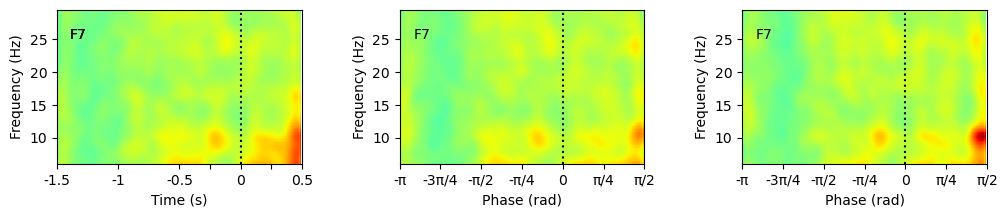

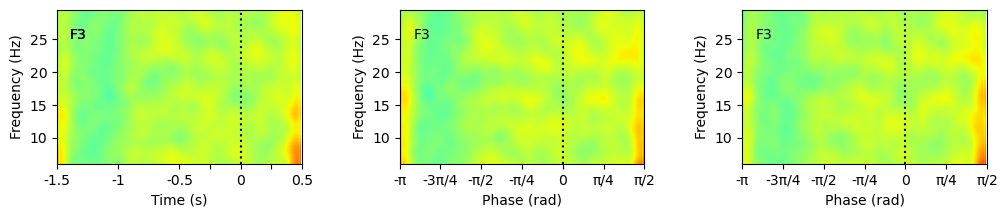

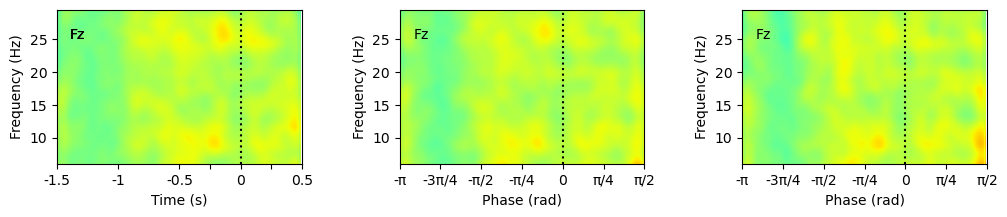

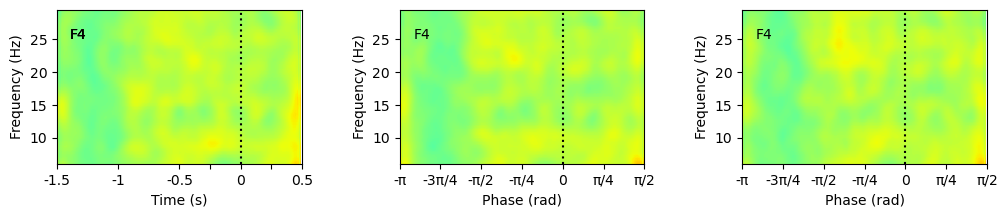

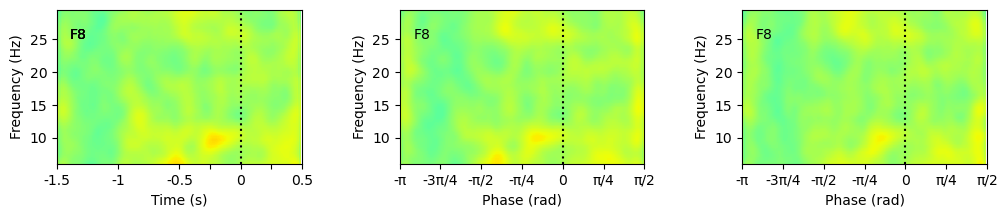

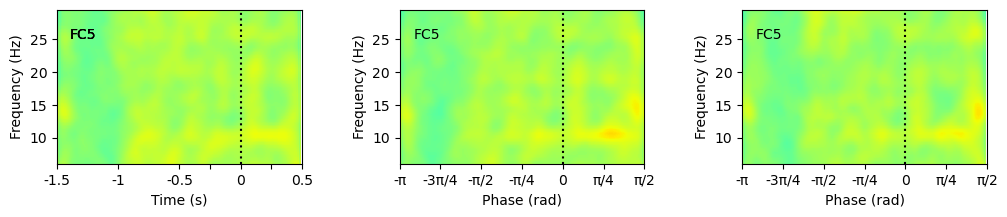

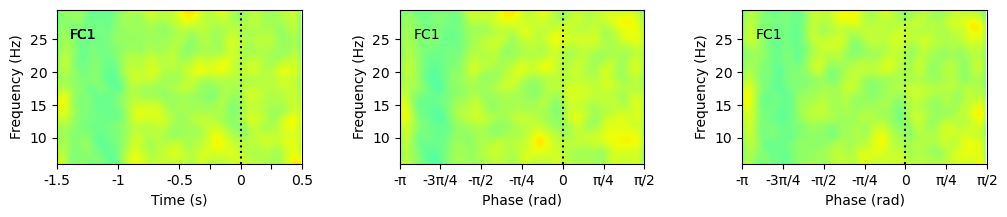

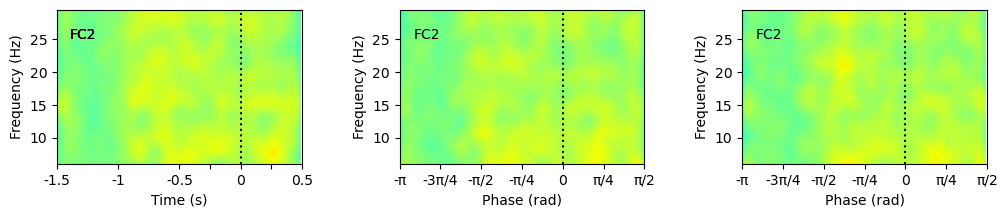

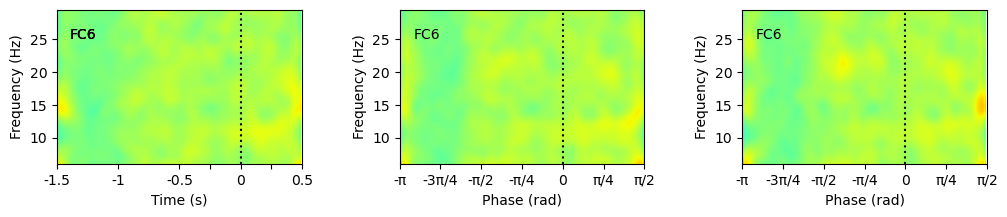

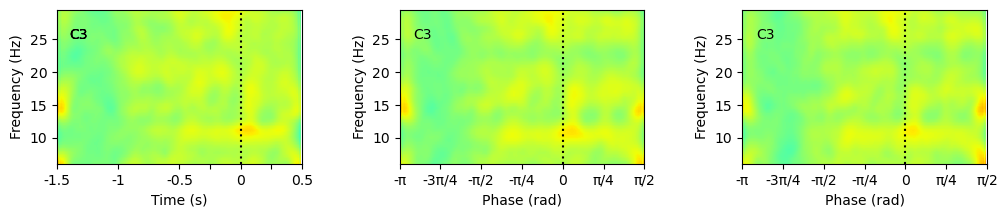

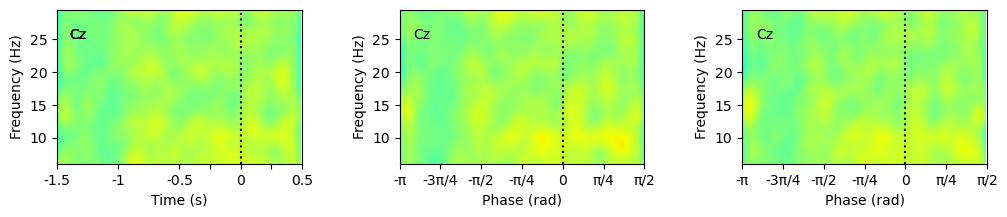

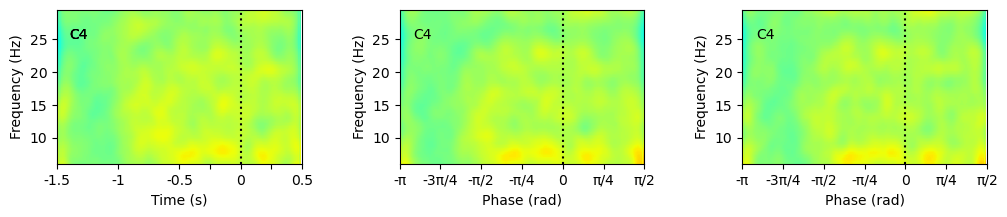

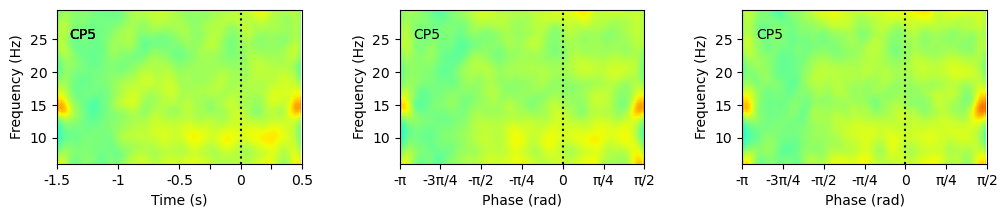

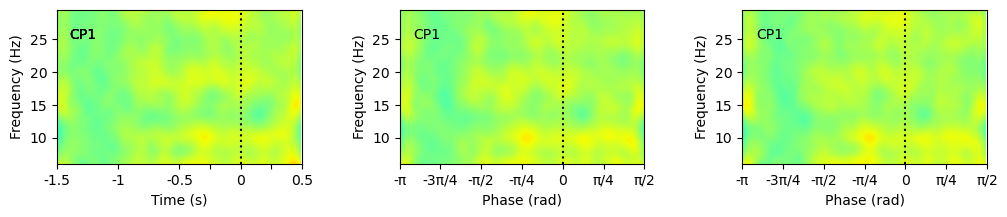

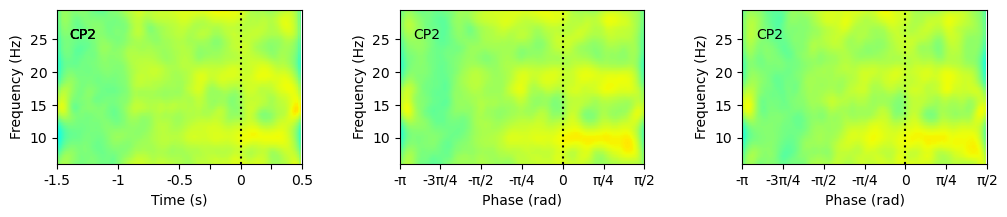

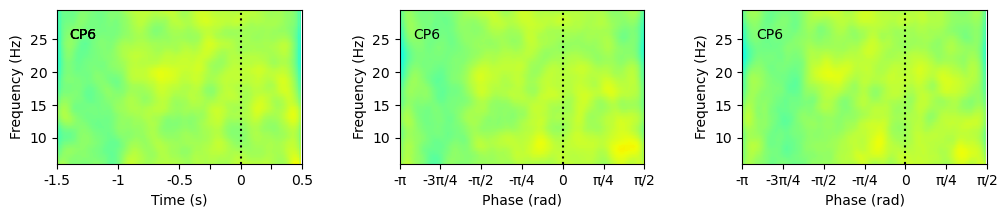

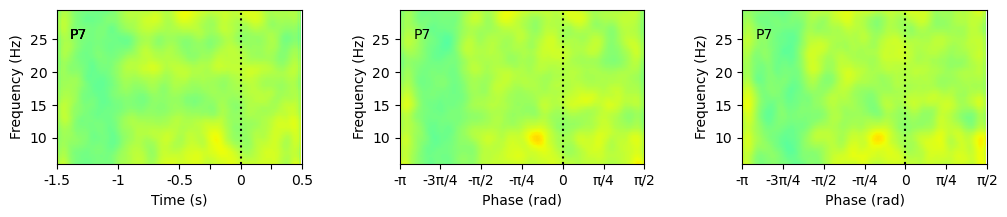

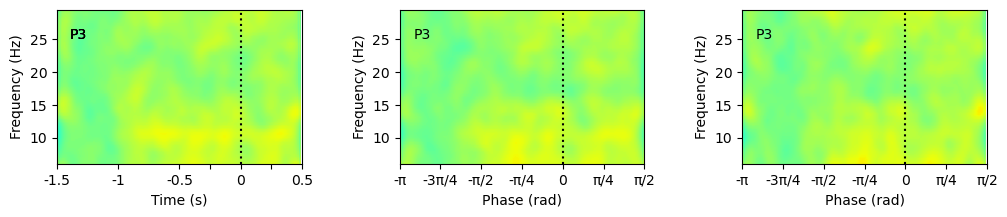

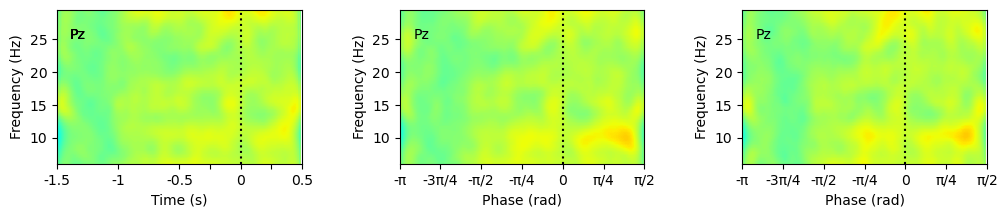

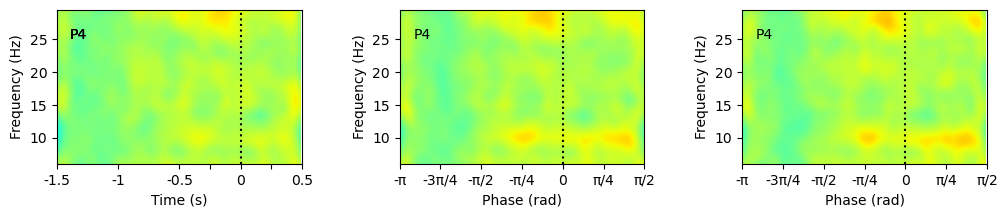

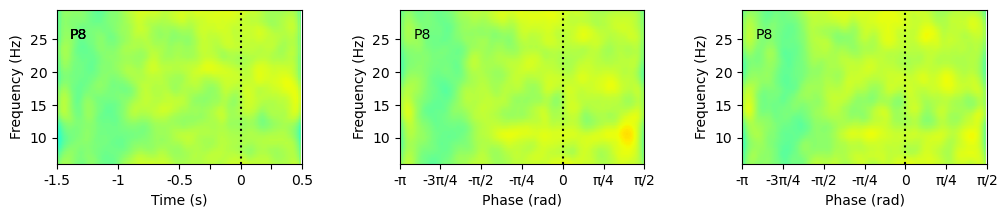

In [28]:
# -------------------------------- VS ---------------------------------
# Show figure with power in all channels 

for chn in range(np.size(ch)):
    fig, axs = plt.subplots(1, 3, figsize=(12, 2))
    c=0
    for row in range(3):
        ax = axs[row]
        vmin = -1 #vmin = -0.00001 # vmin = min_P[col]
        vmax = 1 #vmax = 0.00001  # vmax = max_P[col]
        pcm=ax.imshow(img_VS[c,chn,:,:],extent=[x_vals[row,0], x_vals[row,1], freqs[0], freqs[-1]],
            aspect='auto', origin='lower', cmap=cmap_P, vmin=vmin, vmax=vmax)
        ax.set_xlabel(xlabels[c])
        ax.set_ylabel('Frequency (Hz)')
        ax.axvline(x = 0, color = 'k', linestyle='dotted')
            #fig.text(x_txt[col], y_txt[row], txts[c], **text_kwargs)
        c=c+2
            #if row==2:
            #    cax = ax.inset_axes([1.08, 1, 0.03, 1.8])
            #    cbar = fig.colorbar(pcm, ax=axs[:, col], ticks=[-0.5, 0, 1, 1.5], cax=cax, shrink=0.6)
            #    cbar.set_label(clabels[col], rotation=270, size='10')
        ax.set_xticks(xtick_vals[row,:], xtick_labels[row,:], color='k')
        axs[row].annotate(ch_names[ch[chn]], xy=xy_PF,  xycoords='data')
        axs[0].annotate(ch_names[ch[chn]], xy=xy_TF,  xycoords='data')
        fig.subplots_adjust(hspace=0.4, wspace=0.4)
    
    plt.show()

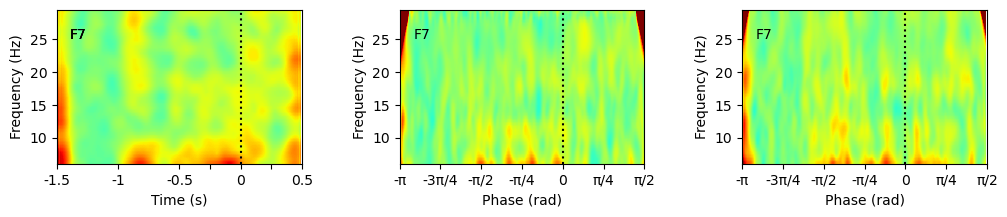

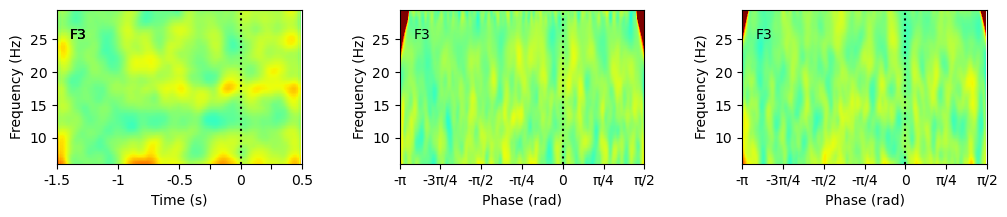

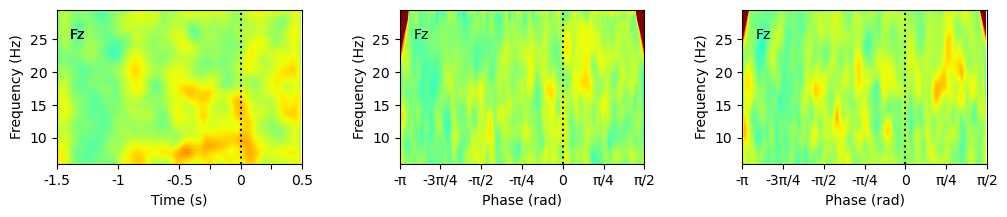

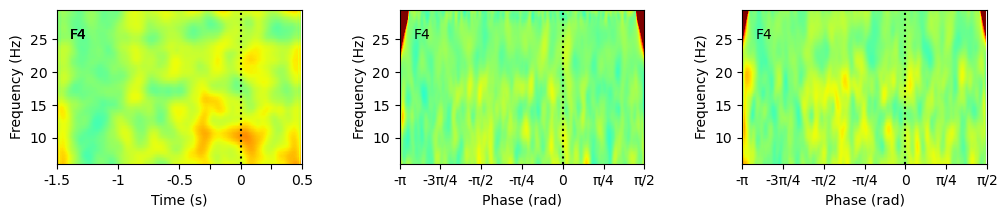

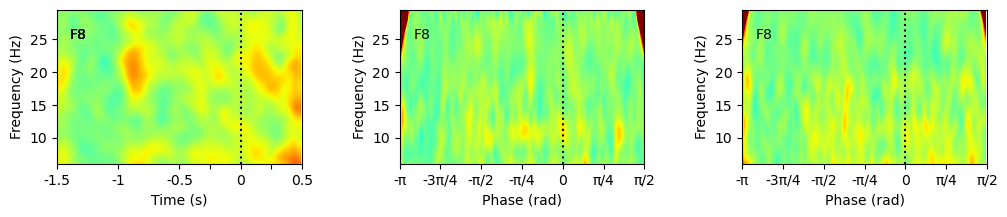

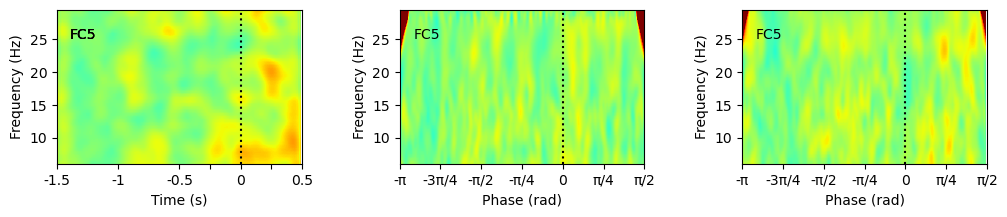

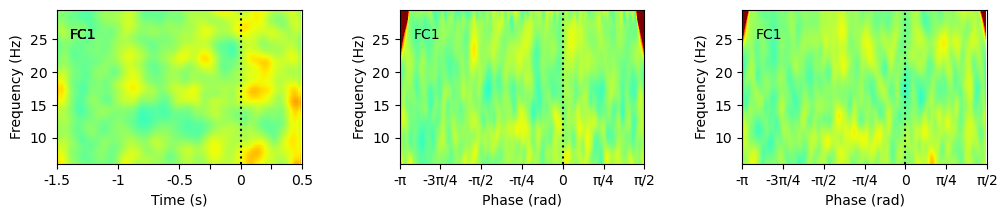

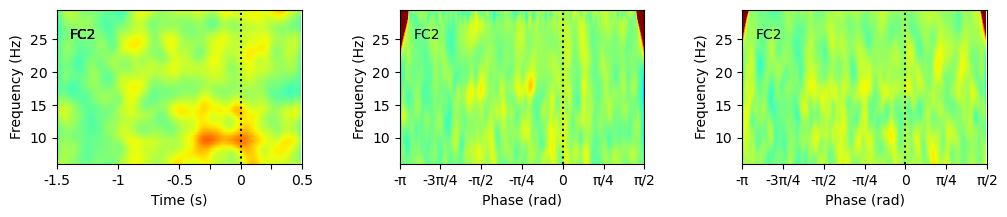

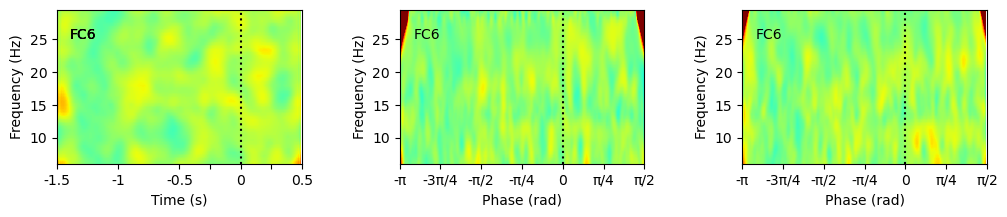

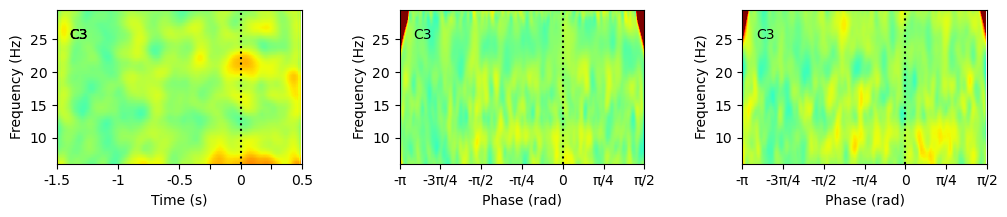

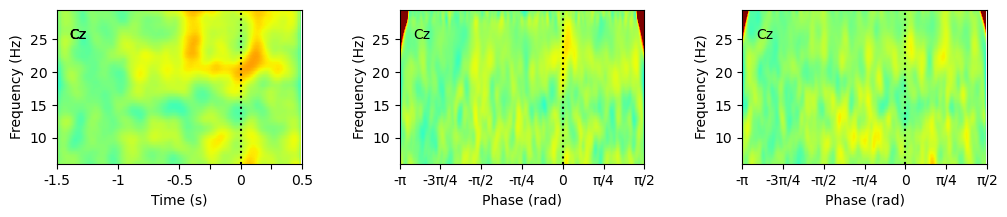

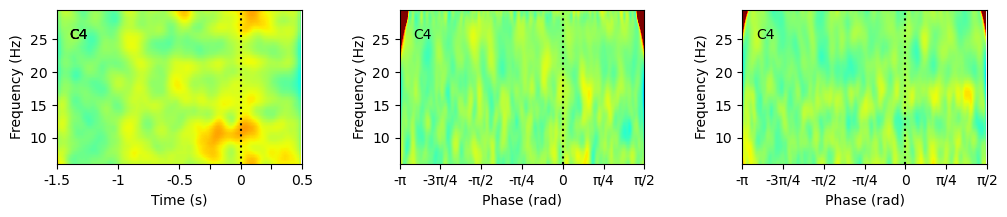

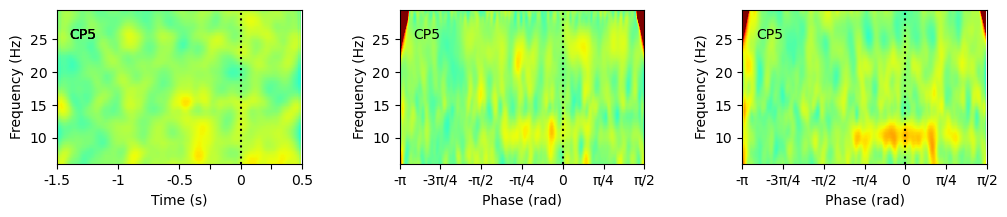

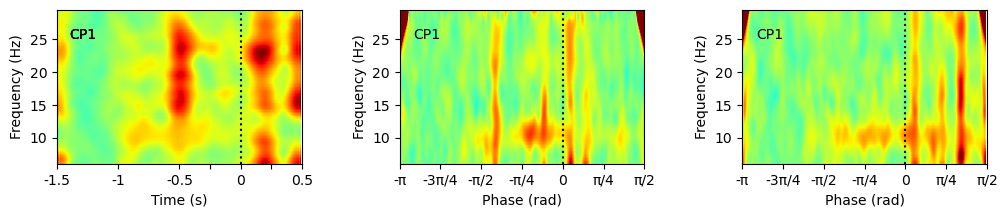

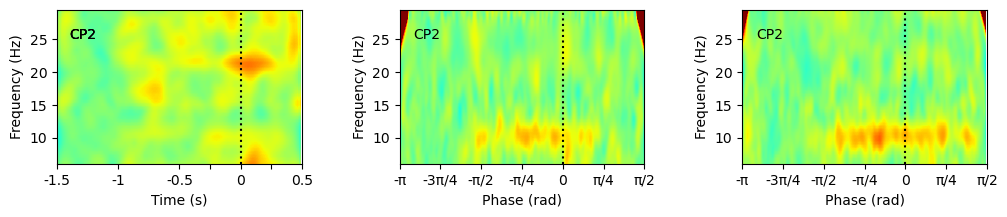

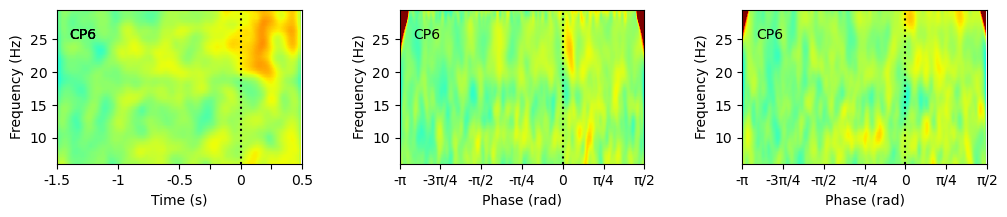

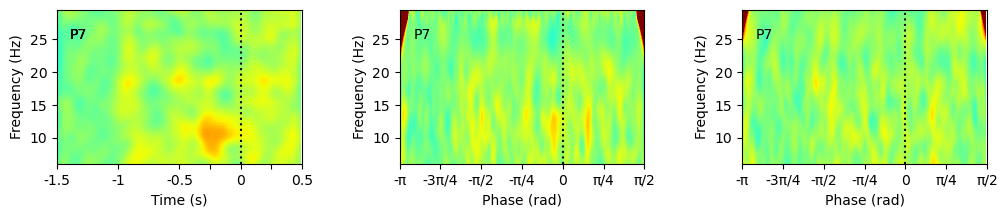

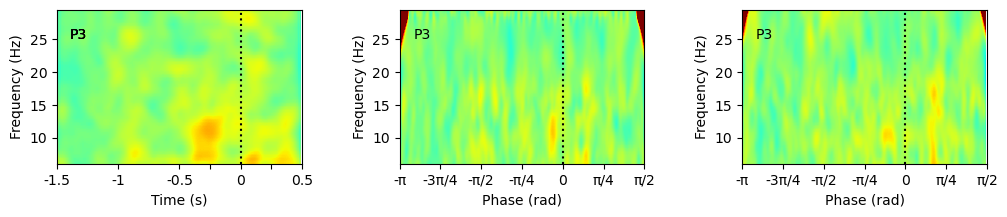

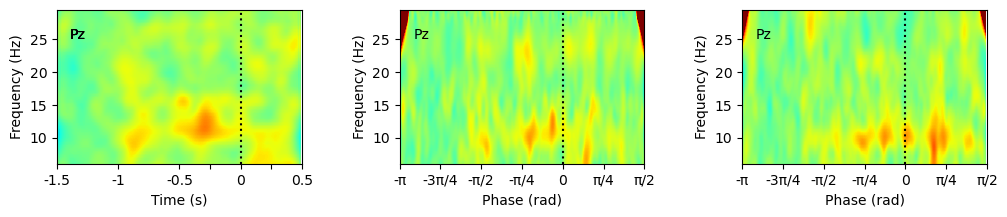

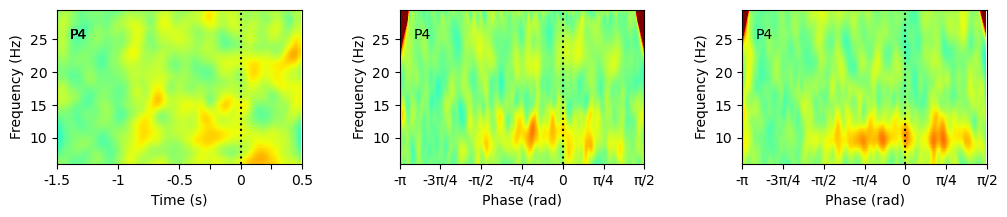

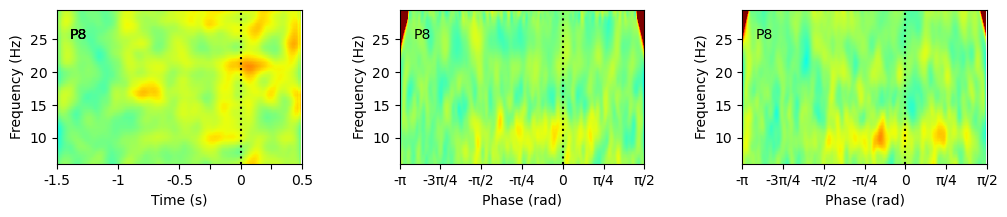

In [29]:
# -------------------------------- LD ----------------------------
# Show figure with power in all channels

for chn in range(np.size(ch)):
    fig, axs = plt.subplots(1, 3, figsize=(12, 2))
    c=0
    for row in range(3):
        ax = axs[row]
        vmin = -1 #vmin = -0.00001 # vmin = min_P[col]
        vmax = 1 #vmax = 0.00001  # vmax = max_P[col]
        pcm=ax.imshow(img_LD[c,chn,:,:],extent=[x_vals[row,0], x_vals[row,1], freqs[0], freqs[-1]],
            aspect='auto', origin='lower', cmap=cmap_P, vmin=vmin, vmax=vmax)
        ax.set_xlabel(xlabels[c])
        ax.set_ylabel('Frequency (Hz)')
        ax.axvline(x = 0, color = 'k', linestyle='dotted')
            #fig.text(x_txt[col], y_txt[row], txts[c], **text_kwargs)
        c=c+2
            #if row==2:
            #    cax = ax.inset_axes([1.08, 1, 0.03, 1.8])
            #    cbar = fig.colorbar(pcm, ax=axs[:, col], ticks=[-0.5, 0, 1, 1.5], cax=cax, shrink=0.6)
            #    cbar.set_label(clabels[col], rotation=270, size='10')
        ax.set_xticks(xtick_vals[row,:], xtick_labels[row,:], color='k')
        axs[row].annotate(ch_names[ch[chn]], xy=xy_PF,  xycoords='data')
        axs[0].annotate(ch_names[ch[chn]], xy=xy_TF,  xycoords='data')
        fig.subplots_adjust(hspace=0.4, wspace=0.4)
    
    plt.show()
    #fig.savefig(fname1,format='pdf')

## Plot TF maps averaged by zones 

In [30]:
# --------------------- VS ------------------------------------
# Average channels according to motor/somatosensorial positions
motor_pos = [3,4,5,8,9]
somato_pos = [12,13,14,18,19]

avg_pow_cfr_VS_motor = np.nanmean(avg_pow_cfr_VS[motor_pos,:,:],axis=0)
avg_pow_cfr_VS_somato = np.nanmean(avg_pow_cfr_VS[somato_pos,:,:],axis=0)

avg_pow_cfr_VS_a_motor = np.nanmean(avg_pow_cfr_VS_a[motor_pos,:,:],axis=0)
avg_pow_cfr_VS_a_somato = np.nanmean(avg_pow_cfr_VS_a[somato_pos,:,:],axis=0)

avg_pow_cfr_by_cycle_VS_motor = np.nanmean(avg_pow_cfr_by_cycle_VS[motor_pos,:,:],axis=0)
avg_pow_cfr_by_cycle_VS_somato = np.nanmean(avg_pow_cfr_by_cycle_VS[somato_pos,:,:],axis=0)


img_VS_zones = np.stack([avg_pow_cfr_VS_motor, avg_pow_cfr_VS_somato,
                         avg_pow_cfr_VS_a_motor, avg_pow_cfr_VS_a_somato,
                         avg_pow_cfr_by_cycle_VS_motor,avg_pow_cfr_by_cycle_VS_somato                        
                        ])

In [31]:
# --------------------- LD ------------------------------------
# Average channels according to motor/somatosensorial positions
#ch_names = ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2',
#       'FC6', 'T7', 'C3', 'Cz', 'C4', 'T8', 'A1', 'CP5', 'CP1', 'CP2',
#       'CP6', 'A2', 'P7', 'P3', 'Pz', 'P4', 'P8', 'O1', 'Oz', 'O2', 'EOG',
#       'resp', 'X', 'Y', 'Z', 'ECG']
#       F7, F3, Fz, F4, F8, FC5, FC1, FC2, FC6, C3, Cz, C4, CP5, CP1, CP2, CP6, P7, P3, Pz, P4, P8
# ch = [2,   3,  4,  5,  6,   7,   8,   9,  10, 12, 13, 14,  17,  18,  19,  20, 22, 23, 24, 25, 26]


motor_pos = [3,4,5] #[3,4,5,8,9]
somato_pos = [12,13,14,18,19]  # [12,13,14,18,19]


avg_pow_cfr_LD_motor = np.nanmean(avg_pow_cfr_LD[motor_pos,:,:],axis=0)
avg_pow_cfr_LD_somato = np.nanmean(avg_pow_cfr_LD[somato_pos,:,:],axis=0)

avg_pow_cfr_LD_a_motor = np.nanmean(avg_pow_cfr_LD_a[motor_pos,:,:],axis=0)
avg_pow_cfr_LD_a_somato = np.nanmean(avg_pow_cfr_LD_a[somato_pos,:,:],axis=0)

avg_pow_cfr_by_cycle_LD_motor = np.nanmean(avg_pow_cfr_by_cycle_LD[motor_pos,:,:],axis=0)
avg_pow_cfr_by_cycle_LD_somato = np.nanmean(avg_pow_cfr_by_cycle_LD[somato_pos,:,:],axis=0)


img_LD_zones = np.stack([avg_pow_cfr_LD_motor, avg_pow_cfr_LD_somato,
                         avg_pow_cfr_LD_a_motor, avg_pow_cfr_LD_a_somato,
                         avg_pow_cfr_by_cycle_LD_motor, avg_pow_cfr_by_cycle_LD_somato                                           
                        ])

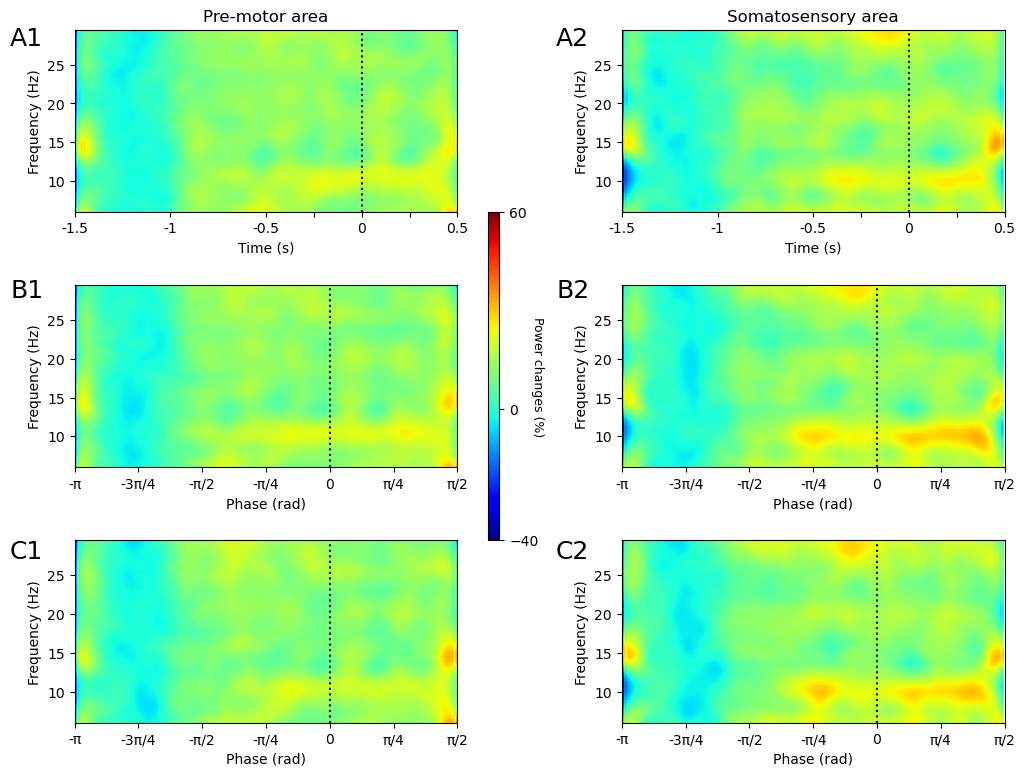

In [32]:
# Show figure with power by zones, VS
#fname3 = 'av_pow_maps_accel_zones_'+ p_ids[ids] +'_VS_'+ posture + '_bl_' + str(baseline_portion*10) +'.pdf'

x_txt = [0.085, 0.54]
y_txt = [0.87, 0.59, 0.30]
txts  = ['A1','A2','B1','B2','C1','C2']
text_kwargs = dict(ha='center', va='center', fontsize=18, color='k')

fig, axs = plt.subplots(3, 2, figsize=(12, 9))
c=0
for row in range(3):
    for col in range(2):
        ax = axs[row][col]
        vmin = -40 # vmin = min_P[col]
        vmax = 60  # vmax = max_P[col]
        if row==0:
            d=0
            if col==0:
                ax.set_title("Pre-motor area")
            else:
                ax.set_title("Somatosensory area")
        else:
            d=2
            
        pcm=ax.imshow(100*img_VS_zones[c,:,:],extent=[x_vals[d,0], x_vals[d,1], freqs[0], freqs[-1]],
            aspect='auto', origin='lower', cmap=cmap_P, vmin=vmin, vmax=vmax)
    
        ax.set_xlabel(xlabels[d])
        ax.set_xticks(xtick_vals[d,:], xtick_labels[d,:], color='k')
        
        ax.set_ylabel('Frequency (Hz)')
        ax.axvline(x = 0, color = 'k', linestyle='dotted')
        if row==2 and col==0:
            cax = ax.inset_axes([1.08, 1, 0.03, 1.8])
            cbar = fig.colorbar(pcm, ax=axs[:][0], ticks=[vmin, 0.0, vmax], cax=cax, shrink=0.6)
            cbar.set_label('Power changes (%)', rotation=270, size='9')
        fig.text(x_txt[col], y_txt[row], txts[c], **text_kwargs)
        c = c+1

fig.subplots_adjust(hspace=0.4, wspace=0.43)
        
plt.show()
#fig.savefig(fname3,format='pdf')

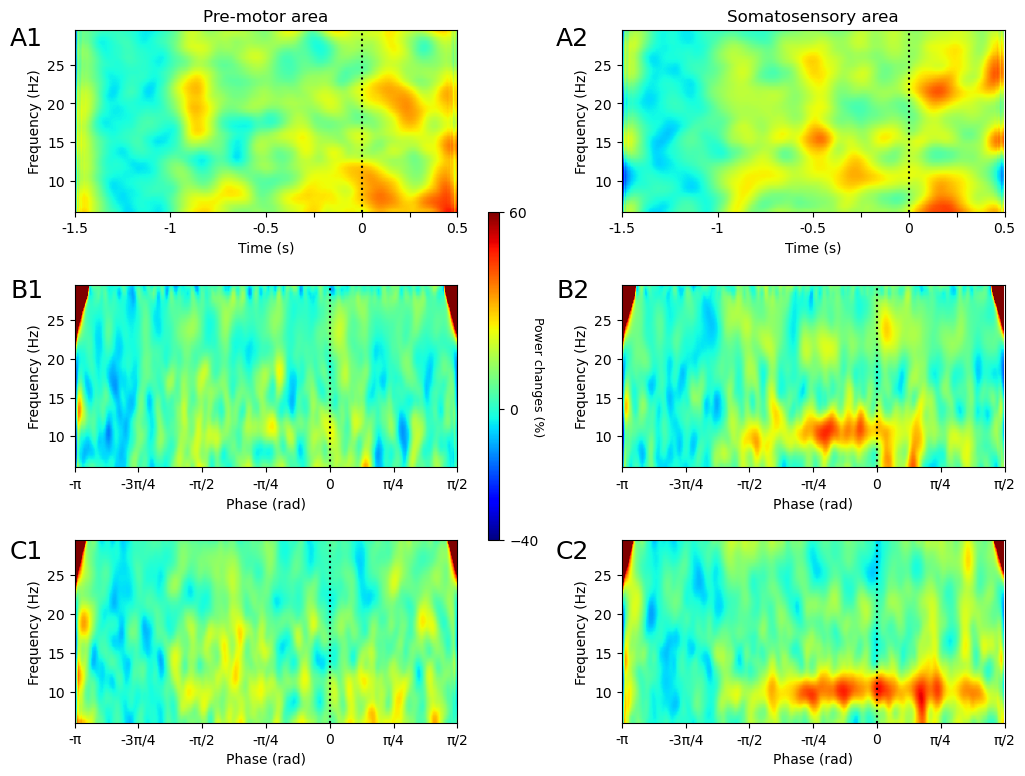

In [33]:
# Show figure with power by zones, LD
#fname4 = 'av_pow_maps_accel_zones_'+ p_ids[ids] +'_LD_'+ posture + '_bl_' + str(baseline_portion*10) +'.pdf'

x_txt = [0.085, 0.54]
y_txt = [0.87, 0.59, 0.30]
txts  = ['A1','A2','B1','B2','C1','C2']
text_kwargs = dict(ha='center', va='center', fontsize=18, color='k')

fig, axs = plt.subplots(3, 2, figsize=(12, 9))
c=0
for row in range(3):
    for col in range(2):
        ax = axs[row][col]
        vmin = -40 # vmin = min_P[col]
        vmax = 60  # vmax = max_P[col]
        if row==0:
            d=0
            if col==0:
                ax.set_title("Pre-motor area")
            else:
                ax.set_title("Somatosensory area")
        else:
            d=2
            
        pcm=ax.imshow(100*img_LD_zones[c,:,:],extent=[x_vals[d,0], x_vals[d,1], freqs[0], freqs[-1]],
            aspect='auto', origin='lower', cmap=cmap_P, vmin=vmin, vmax=vmax)
    
        ax.set_xlabel(xlabels[d])
        ax.set_xticks(xtick_vals[d,:], xtick_labels[d,:], color='k')
        
        ax.set_ylabel('Frequency (Hz)')
        ax.axvline(x = 0, color = 'k', linestyle='dotted')
        if row==2 and col==0:
            cax = ax.inset_axes([1.08, 1, 0.03, 1.8])
            cbar = fig.colorbar(pcm, ax=axs[:][0], ticks=[vmin, 0.0, vmax], cax=cax, shrink=0.6)
            cbar.set_label('Power changes (%)', rotation=270, size='9')
        fig.text(x_txt[col], y_txt[row], txts[c], **text_kwargs)
        c = c+1

fig.subplots_adjust(hspace=0.4, wspace=0.43)
        
plt.show()
#fig.savefig(fname4,format='pdf')

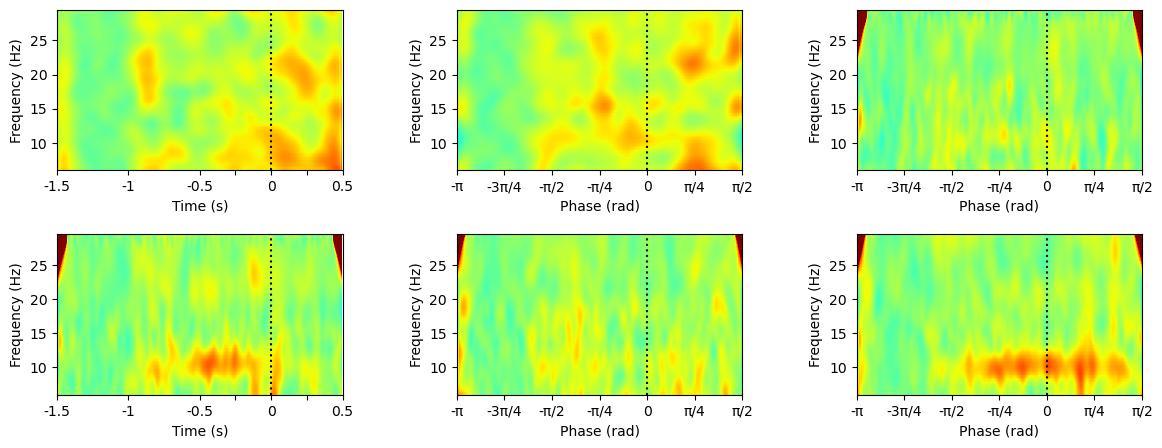

In [42]:
# ---------------------- LD ----------------------------
# Show figure with power by zones
#fname5 = 'av_pow_maps_accel_zones_'+ p_ids[ids] +'_LD_'+ posture + '_bl_' + str(baseline_portion*10) +'.pdf'

fig, axs = plt.subplots(2, 3, figsize=(14, 5))
c=0
for row in range(2):
    d=0
    for col in range(3):
        ax = axs[row][col]
        vmin = -0.75 # vmin = min_P[col]
        vmax = 0.75  # vmax = max_P[col]
        pcm=ax.imshow(img_LD_zones[c,:,:],extent=[x_vals[d,0], x_vals[d,1], freqs[0], freqs[-1]],
            aspect='auto', origin='lower', cmap=cmap_P, vmin=vmin, vmax=vmax)
        
        ax.set_ylabel('Frequency (Hz)')
        ax.axvline(x = 0, color = 'k', linestyle='dotted')
        
        fig.subplots_adjust(hspace=0.4, wspace=0.4)

        ax.set_xticks(xtick_vals[d,:], xtick_labels[d,:], color='k')
        ax.set_xlabel(xlabels[d+1])
        c=c+1
        d=d+1

    
plt.show()
#fig.savefig(fname5,format='pdf')